by Gerard Caravaca, AI engineer.

# **Histogram of Oriented Gaussians for pederastrian detection**

In [2]:
#needed imports 

import numpy as np
from matplotlib import pyplot as plt
import os
from skimage import color, data, exposure, feature, filters, io, transform 
from google.colab import drive
drive.mount('/content/drive')

images_path='/content/drive/MyDrive/Uni projects/HOGs/images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*  Template slection 

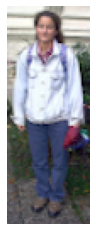

In [4]:
#read template img
template = io.imread(images_path+'/person_template.bmp')
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.show()

*  HOG parameters analysis

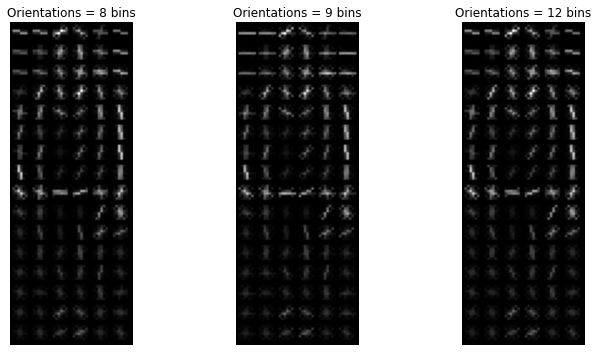

In [5]:
# First step -> orientations parameter selection
orientations=[8,9,12]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for n in range(0, len(orientations)):
    _, hog_image = feature.hog(template, orientations=orientations[n], visualize=True)
    ax[n].imshow(hog_image, cmap='gray')
    ax[n].set_title('Orientations = ' + str(orientations[n]) + ' bins')
    ax[n].axis('off')

plt.tight_layout()
plt.show()

We cannot observe a big difference, although we can see that increasing the number of bins worsens the performance. So we decided that 9 bins is enough.

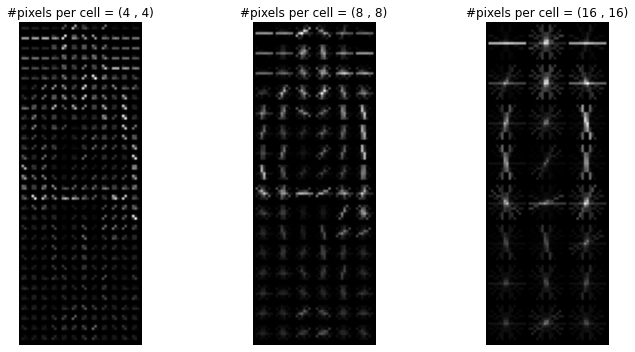

In [6]:
# Second step -> #pixels per cell selection:
pixels_cell=[4,8,16]

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for n in range(0, len(pixels_cell)):
    _, hog_image = feature.hog(template, orientations=9,pixels_per_cell=(pixels_cell[n], pixels_cell[n]), visualize=True)
    ax[n].imshow(hog_image, cmap='gray')
    ax[n].set_title('#pixels per cell = (' + str(pixels_cell[n]) + ' , ' + str(pixels_cell[n]) + ')')
    ax[n].axis('off')

plt.tight_layout()
plt.show()

With 16 pixels per cell we lose a lot of image information and it seems that with 4 pixels per cell we add too much noise. For this reason we believe that the HOG of (8,8) pixels per cell seems to be the best representation of a person's silhouette.

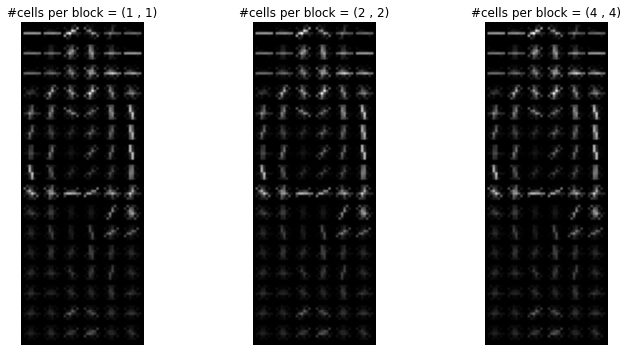

In [7]:
# Third step -> #cells per block selection:
cells_block=[1,2,4] 

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for n in range(0, len(cells_block)):
    _, hog_image = feature.hog(template, orientations=9,pixels_per_cell=(8,8), cells_per_block=(cells_block[n], cells_block[n]), visualize=True)
    ax[n].imshow(hog_image, cmap='gray')
    ax[n].set_title('#cells per block = (' + str(cells_block[n]) + ' , ' + str(cells_block[n]) + ')')
    ax[n].axis('off')

plt.tight_layout()
plt.show()

Not much difference can be observed in these cases. So we will choose the middle case, the one explained in the theory class, which is 2 cells per block.

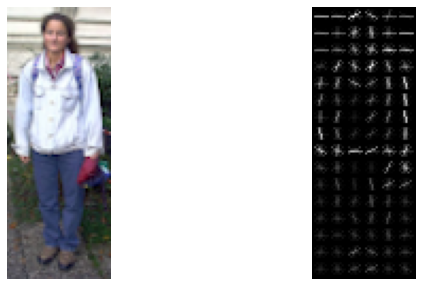

In [8]:
#Final HOG obtained
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(template, cmap='gray')
ax[0].axis('off')
fd_template, hog_template = feature.hog(template, orientations=9,pixels_per_cell=(8,8), cells_per_block=(2, 2), visualize=True)
ax[1].imshow(hog_template, cmap='gray')
ax[1].axis('off')
plt.show()

*  Analyse pederastian detection with test images

In [10]:
#reading test images
path=images_path + '/pedestrians'
images=[]
for filename in os.listdir(path):
  if os.path.isfile(os.path.join(path, filename)) and filename != 'desktop.ini':
        images.append(io.imread(path + '/' + filename))

In [11]:
from skimage.util.shape import view_as_windows
#functions needed to apply HOGs method

#sliding window to get HOGs descriptor
def sliding_window(img, window_size, hog_template_shape, step_size=5):
  windows=view_as_windows(img, window_shape=window_size, step=step_size)
  hog_des=np.zeros((windows.shape[0], windows.shape[1],hog_template_shape[0]))
  for i in range(0, windows.shape[0]):
    for j in range(0, windows.shape[1]):
     fd =feature.hog(image=windows[i,j,:], orientations=9,pixels_per_cell=(8,8),cells_per_block=(2, 2), visualize=False)
     hog_des[i,j]=fd
  return hog_des, windows

# Euclidean distance between arrays
def euclidean_dist(x,y):
  dist = np.linalg.norm(x - y)
  return dist

# Dot product between arrays
def dot_product(x,y):
  dist = np.dot(x, y)
  return dist

# Compute both distance matrix, each cell is the similarity/distance between windows and template
def compute_dist_matrix(windows_shape,hog_des, hog_template):
  ed_matrix=np.zeros(windows_shape)
  dp_matrix=np.zeros(windows_shape)
  for i in range(0, windows_shape[0]):
    for j in range(0, windows_shape[1]):
      ed_matrix[i,j]=euclidean_dist(hog_des[i,j], hog_template)
      dp_matrix[i,j]=dot_product(hog_des[i,j], hog_template)
  return ed_matrix, dp_matrix


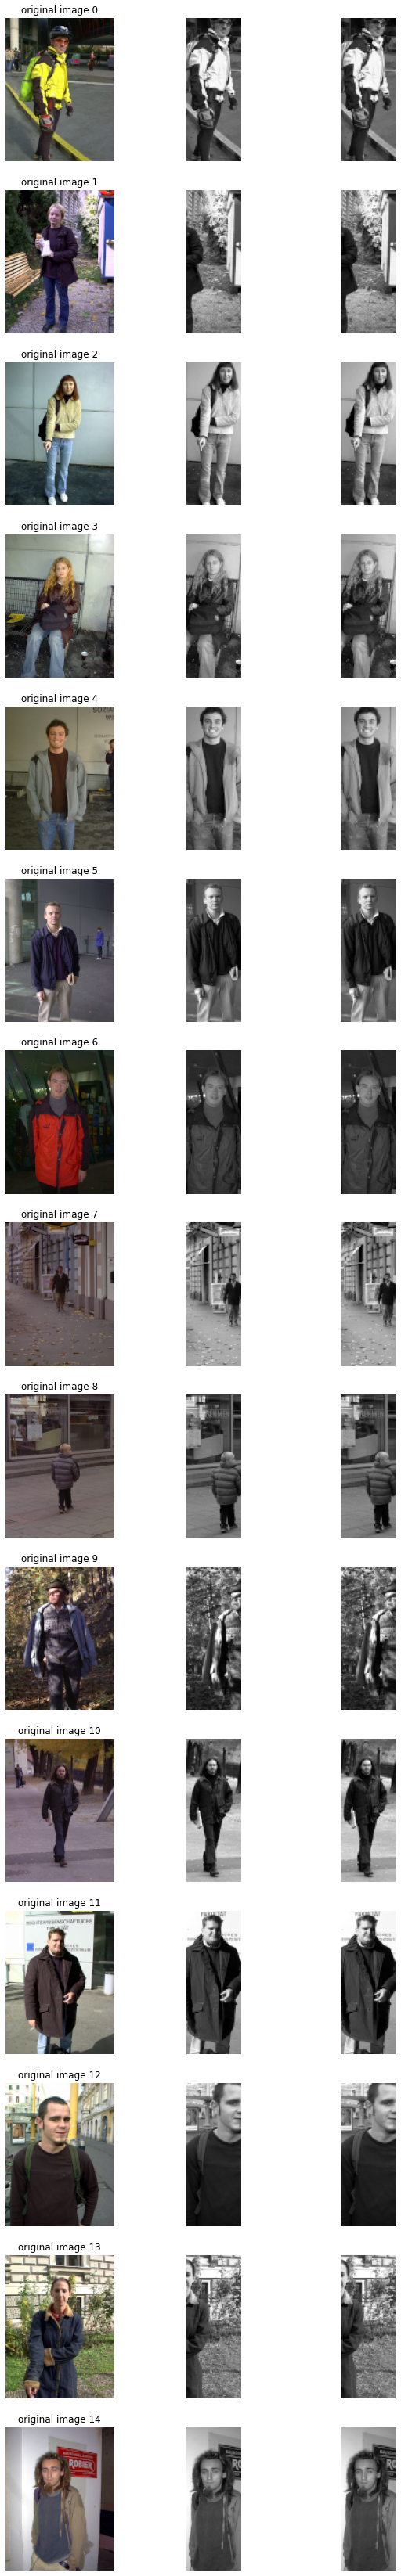

In [12]:
fig=plt.figure()
fig.set_figwidth(10)
fig.set_figheight(60)
off=1

for i in range(0, len(images)):
  #apply HOG for each image
  img=images[i]
  hog_des, windows=sliding_window(color.rgb2gray(img)*255, (template.shape[0], template.shape[1]), fd_template.shape)
  ed, dp= compute_dist_matrix((windows.shape[0], windows.shape[1]),hog_des,fd_template)

  #get indices for best matching
  best_ed_id=np.argwhere(ed == np.min(ed))[0]
  best_dp_id=np.argwhere(dp == np.max(dp))[0]

  #best matching windows
  window_ed=windows[best_ed_id[0], best_ed_id[1], :]
  window_dp=windows[best_dp_id[0], best_dp_id[1], :]

  #visualization
  results=[img, window_ed, window_dp]
  titles=['original image', 'HOG match (euclidean distance)', 'HOG match (dot product)'] 
  for j in range(0, len(results)):
    fig.add_subplot(len(images), 3, off)
    plt.imshow(results[j], cmap='gray')
    if j == 0 : plt.title(titles[j] + ' ' + str(i))
    plt.axis('off')
    off+=1

plt.subplots_adjust(wspace=None, hspace=None)
plt.show()

Of the 15 cases we have used to test the technique, it has worked perfectly in 9 of these cases. We can distinguish three reasons why this method may have failed. First of all, images number 9, 12 and 14 (in the respective order in which we have printed the images) are cases where the image of the person shows a very different scale from the template. Next, for image 8 the method may be failing because the silhouette of the person is cropped. Finally, for images number 1 and 11, the problem may be due to the fact that the pose of the person in the image is different from the one in the template or even due to the clothing worn (as it modifies the silhouette of the body).

Template matching is a simple way to detect identical patches on the same image. But this technique is sensitive to lighting changes and in general to mask variations (rotation, scaling, general appearance...). For this reason, we need more complex techniques to solve complex real-world problems. For this we have image descriptors. In the specific case of HOG, as the gradient orientation is not sensitive to illumination changes, we obtain a model that is less sensitive to illumination changes and more general for object matching.

# **References**

*  [Hog algorithm skimage](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html)

*  [Theory of HOGs descriptors in wikipedia](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)